We'll make two studies:
1. Create an ML model to forecast/predict the level of unemployment in the US.
2. Create a linear model to predict the same, but for another purpose: to check if the varible "stock price of SP500" is statistically significant for the model (i.e., if it's coefficient should be zero or different from zero). For that, we'll do a hypothesis test.


In [ ]:
# economic information from yahoo finance, already installed it
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import datetime

We'll import our unemployment data from the package pandas_datareader, which has axes to a collection of datasets from the Federal Reserve of the US.
For reference, we'll consider the following framework of time: from the 1st of January of 2000 till the 21st December 2025.

In [2]:
# set time period of our study
start_date = '2000-01-01'
end_date = '2025-12-21'

unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)
unemployment.head(32)

,UNRATE
DATE,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0
2000-06-01,4.0
2000-07-01,4.0
2000-08-01,4.1
2000-09-01,3.9


I want to study the depndence of unemployment with respect of financial and social data: price of sp500 bonds, number of unemployment benefit applications, industrial production, etc.
For the sp500 bonds data we'll extract the information from the Yahoo Finance package.
For the other data that I am interested in, I will import it from the datasets in the federal reserve (that can be found using the pandas_datareader package).

In [3]:
# download sp500 from yahoo finance
# data till today
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-12-21', auto_adjust  = True)
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


The columns close, high, low and open have very similar values, since they describe the evolution regarding the price of the sp500 companies' price of the bonds. Maybe it's not a good idea to include all of these in the model, since they might be very correlated. Let's check that:

Text(0.5, 1.0, 'Correlation Matrix of S&P 500 Features')

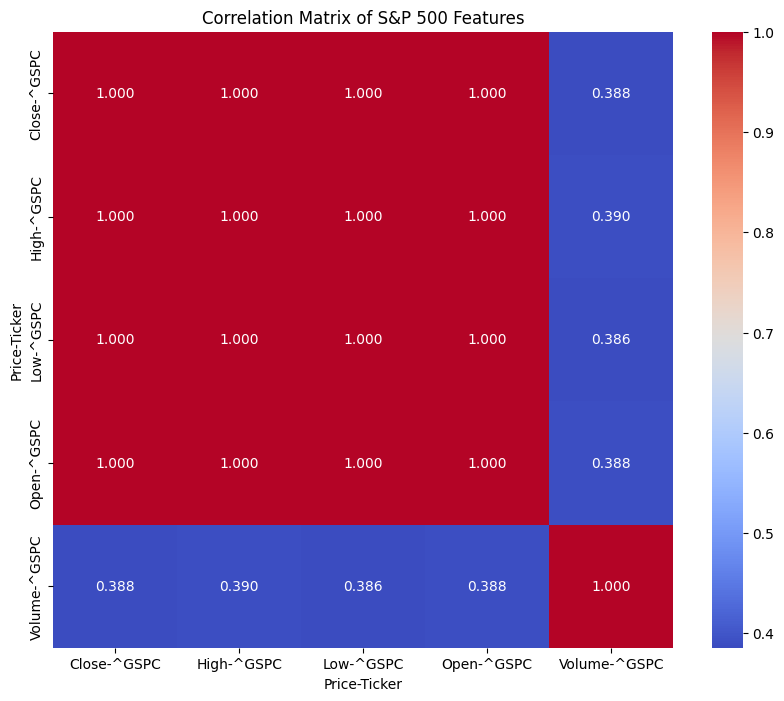

In [4]:
# correlation matrix of sp500 printed in a fancy way
corr_matrix = sp500.corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix of S&P 500 Features')

In fact they are! So it won't be a good idea to "throw" all these variables to the model and, as if it were a black-box, think that it will find the intrinsicate and often complicated dependencies.
We'll keep it simple with this set of varibles, and will only use the closing price of the bonds.

In [5]:
sp500_reduced = sp500["Close"]

# convert into dataframe to treat more easily
sp500_reduced = pd.DataFrame(sp500_reduced)
sp500_reduced.head()

Ticker,^GSPC
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971


Now we'll be downloading other social and economical data that I think are interesting for our model to train on. We'll use the same start and end dates as before.

In [6]:
# I will create a dictionary with the FRED indicators I want to download and an alias for each one
fred_indicators = {
    'ICSA': 'Initial_Claims',          
    'FEDFUNDS': 'Interest_Rate',        
    'INDPRO': 'Industrial_Production',  
    'UMCSENT': 'Consumer_Sentiment',    
    'CPIAUCSL': 'CPI_Inflation',        
}

print("Descargando datos de FRED...")
df = web.DataReader(list(fred_indicators.keys()), 'fred', start_date, end_date)

# Rename columns to have a human understandable names :)
df = df.rename(columns=fred_indicators)
df.head(32) # plot more than a month 

Descargando datos de FRED...


,Initial_Claims,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation
DATE,,,,,
2000-01-01,286000.0,5.45,91.5380,112.0,169.3
2000-01-08,298000.0,NaN,NaN,NaN,NaN
2000-01-15,289000.0,NaN,NaN,NaN,NaN
2000-01-22,284000.0,NaN,NaN,NaN,NaN
2000-01-29,285000.0,NaN,NaN,NaN,NaN
2000-02-01,NaN,5.73,91.8239,111.3,170.0
2000-02-05,312000.0,NaN,NaN,NaN,NaN
2000-02-12,300000.0,NaN,NaN,NaN,NaN
2000-02-19,283000.0,NaN,NaN,NaN,NaN


What's happening!? So many NaN! Is our data wrong? No it is not, but these variables have different periodicities. So we'll have to set one common periodicity across all our variables (and also the target ones) so that our model can be trained properly. I will use months. The following steps are towards that objective.

In [7]:
# join df and sp500_reduced on the date index
df = df.join(sp500_reduced, how='outer')
# rename the column from Close to SP500_Index
df = df.rename(columns={'^GSPC': 'SP500_Index'})
df.head(60)

,Initial_Claims,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation,SP500_Index
2000-01-01,286000.0,5.45,91.5380,112.0,169.3,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN,1455.219971
2000-01-04,NaN,NaN,NaN,NaN,NaN,1399.420044
2000-01-05,NaN,NaN,NaN,NaN,NaN,1402.109985
2000-01-06,NaN,NaN,NaN,NaN,NaN,1403.449951
2000-01-07,NaN,NaN,NaN,NaN,NaN,1441.469971
2000-01-08,298000.0,NaN,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN,NaN,1457.599976
2000-01-11,NaN,NaN,NaN,NaN,NaN,1438.560059
2000-01-12,NaN,NaN,NaN,NaN,NaN,1432.250000


In [8]:
# we'll also join the unemployment data
df = df.join(unemployment, how='outer')
df.head()

,Initial_Claims,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation,SP500_Index,UNRATE
2000-01-01,286000.0,5.45,91.538,112.0,169.3,NaN,4.0
2000-01-03,NaN,NaN,NaN,NaN,NaN,1455.219971,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,1399.420044,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,1402.109985,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,1403.449951,NaN


Great! Now that we have grouped our data, we will put it in a nice "monthly" format. For that, there are some columns where we have to decide what to with the daily data. I will apply the following transformations:
1. Average the sp500 bond price for the month (taking into account that this is a daily variable).
2. Average the number of claims per month (taking into accoutn that this is a weekly variable).
3. Average the unemployment rate per month (taking into account that this is a daily varible).
4. The rest of the variables are already in a monthly format.


In [ ]:
df_monthly = pd.DataFrame()
df_monthly['SP500_Index'] = df['SP500_Index'].resample('ME').mean()
df_monthly['Initial_Claims'] = df['Initial_Claims'].resample('ME').mean()
df_monthly['Unemployment_Rate'] = df['UNRATE'].resample('ME').mean()
df_monthly['Interest_Rate'] = df['Interest_Rate'].resample('ME').last()
df_monthly['Industrial_Production'] = df['Industrial_Production'].resample('ME').last()
df_monthly['Consumer_Sentiment'] = df['Consumer_Sentiment'].resample('ME').last()
df_monthly['CPI_Inflation'] = df['CPI_Inflation'].resample('ME').last()
df_monthly.head()

,SP500_Index,Initial_Claims,Unemployment_Rate,Interest_Rate,Industrial_Production,Consumer_Sentiment,CPI_Inflation
2000-01-31,1425.585504,288400.0,4.0,5.45,91.5380,112.0,169.3
2000-02-29,1388.874500,293750.0,4.1,5.73,91.8239,111.3,170.0
2000-03-31,1442.212599,274750.0,4.0,5.85,92.1504,107.1,171.0
2000-04-30,1461.355257,271600.0,3.8,6.02,92.6989,109.2,170.9
2000-05-31,1418.479548,282250.0,4.0,6.27,92.9499,110.7,171.2


In [10]:
df_monthly.shape

(312, 7)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare features and target variable
features = [
    'SP500_Index',
    'Initial_Claims',
    'Interest_Rate',
    'Industrial_Production',
    'Consumer_Sentiment',
    'CPI_Inflation'
]

# Create target, the unemployment rate of the NEXT month, by applying shift(-1)
df_monthly['Target_Next_Month_Unemployment'] = df_monthly['Unemployment_Rate'].shift(-1)

# Select and clean Select X,y
data = df_monthly[features + ['Target_Next_Month_Unemployment']].dropna()
X = data[features].astype(float)
y = data['Target_Next_Month_Unemployment'].astype(float)

# Train test split at rates 80% train, 20% test. Since it's time series, no shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a random forest regressor
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# predict and evaluate results
predictions = model.predict(X_test)
mae = (y_test - predictions).abs().mean()
mape = ((y_test - predictions).abs() / y_test).mean() * 100

print("--- RESULTS ---")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


--- RESULTS ---
MAE: 1.1516
MAPE: 27.03%


Observe that the achieved results show a MAPE of around the 27%. This might seem like a high value, but we have to take into account that we are working with real world data and that we are interested in the shape that our model predicts. Let's see that in the following plots:

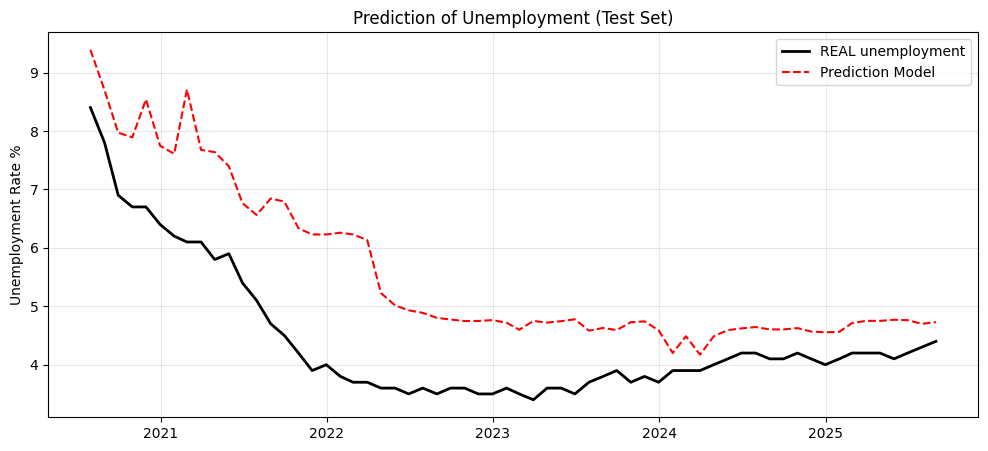

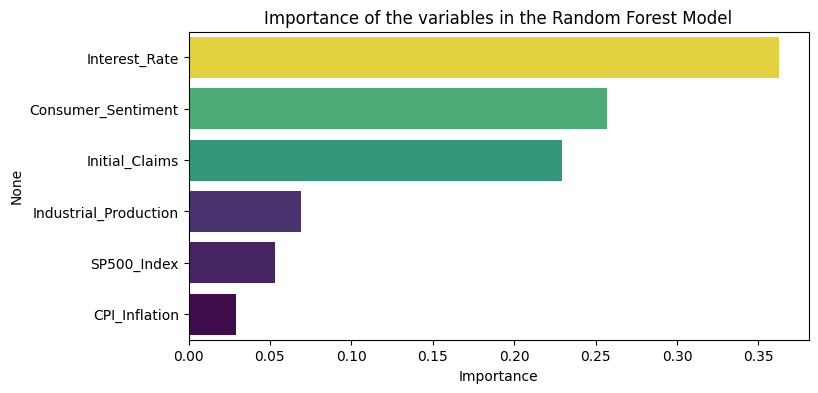

In [36]:
# plots
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='REAL unemployment', color='black', linewidth=2)
plt.plot(y_test.index, predictions, label='Prediction Model', color='red', linestyle='--')
plt.title('Prediction of Unemployment (Test Set)')
plt.ylabel('Unemployment Rate %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# importance of the variables
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index, palette='viridis', hue = importances.values, legend=False)
plt.title('Importance of the variables in the Random Forest Model')
plt.xlabel('Importance')
plt.show()

We can see that, although our model slightly tends to overestimat unemployment, it is able to appropiately guess the tendency of unemployment (if if it's going to increase or decrease and how heavy this effect will be).

Moreover, the second plot allows us to understand the importance that the model assigns to the variables in order to predict unemployment. The most influential ones are interest rates and consumer sentiment. This result is personally surprising for me, as I would've expected that for forecasting the variable `Initial_Claims` would be the most important. And I say that because this variable means people that have been recently registered as "job-seekers". A possible explanation for this effect is that since this is the employment demand for the previous month that we are trying to predict, it looses importance with respect to other variables. 

Maybe we could check this claim by training the model for predicting the unemployment for the current month (a zero shift.)

--- RESULTS ---
MAE: 0.7590
MAPE: 17.76%


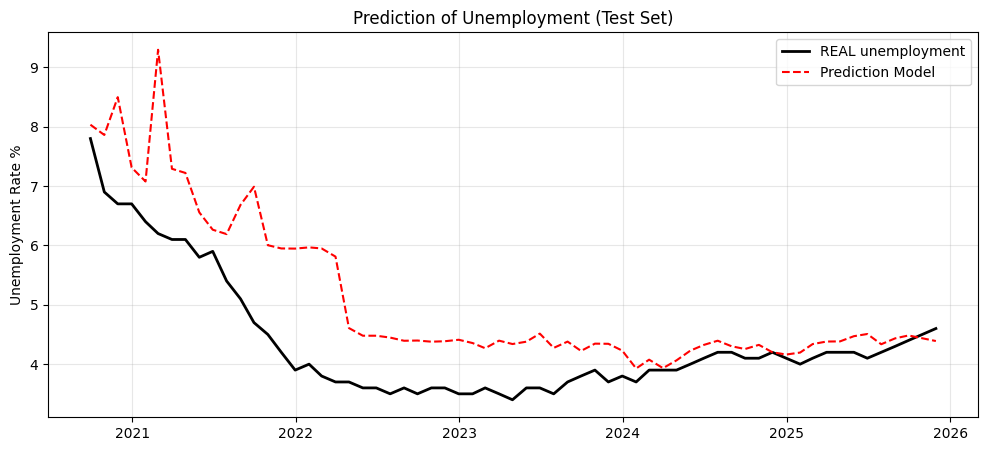

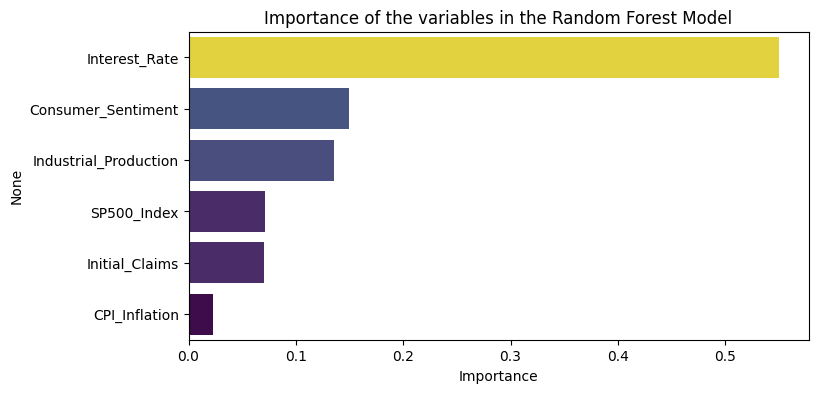

In [32]:
# Create new dataset and target, the unemployment rate of this month, by taking all the columns of the df_monthly except target_next_month
df_monthly_new = df_monthly.copy()
df_monthly_new.drop(columns=['Target_Next_Month_Unemployment'], inplace=True)
# Select and clean Select X,y
# data is the same as before but now the target is unemployment_rate of this month
data = df_monthly_new[features + ["Unemployment_Rate"]].dropna()
X_new = data[features].astype(float)
y_new = data["Unemployment_Rate"].astype(float)

# Train test split at rates 80% train, 20% test. Since it's time series, no shuffle
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, shuffle=False)
# Train a random forest regressor
model_new = RandomForestRegressor(n_estimators=200, random_state=42)
model_new.fit(X_train_new, y_train_new)

# predict and evaluate results
predictions_new = model_new.predict(X_test_new)
mae_new = (y_test_new - predictions_new).abs().mean()
mape_new = ((y_test_new - predictions_new).abs() / y_test_new).mean() * 100

print("--- RESULTS ---")
print(f"MAE: {mae_new:.4f}")
print(f"MAPE: {mape_new:.2f}%")

# plots
plt.figure(figsize=(12,5))
plt.plot(y_test_new.index, y_test_new, label='REAL unemployment', color='black', linewidth=2)
plt.plot(y_test_new.index, predictions_new, label='Prediction Model', color='red', linestyle='--')
plt.title('Prediction of Unemployment (Test Set)')
plt.ylabel('Unemployment Rate %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# importance of the variables
importances_new = pd.Series(model_new.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances_new.values, y=importances_new.index, palette='viridis', hue = importances_new.values, legend=False)
plt.title('Importance of the variables in the Random Forest Model')
plt.xlabel('Importance')
plt.show()

😲! I wasn't expecting that. Interest rates are even more important now, and the importance of the initial claims has been reduced. However, if we place our "economist helmet" and try to make sense of the results, we can arguee that: higher rates increase borrowing costs, slowing business investment, consumer spending, and growth, leading to reduced hiring or layoffs, while lower rates decrease borrowing costs, encouraging investment, boosting demand, and spurring job creation, thereby lowering unemployment. That's why it's so important.

On another note, this model clearly works better (lower MAE and MAPE) because we are trying to predict the current unemployment, using data from the same month. This does not come as a surprise, since the effect from the current economical and social data is more direct. 

Now, for the second part of my project I will create a linear model for predicting the unemployment but with another purpose: to see if the variable regarding the SP500 bond price is a variable worth to take into account (i.e., if $\beta_{\text{SP500}} = 0$ or $\beta_{\text{SP500}} \neq 0$ ).
In this part, I am not going to be studying the model per se, but the statistical study of the coefficient.

--- LINEAR MODEL RESULTS ---
MAE: 1.3283
MAPE: 31.73%


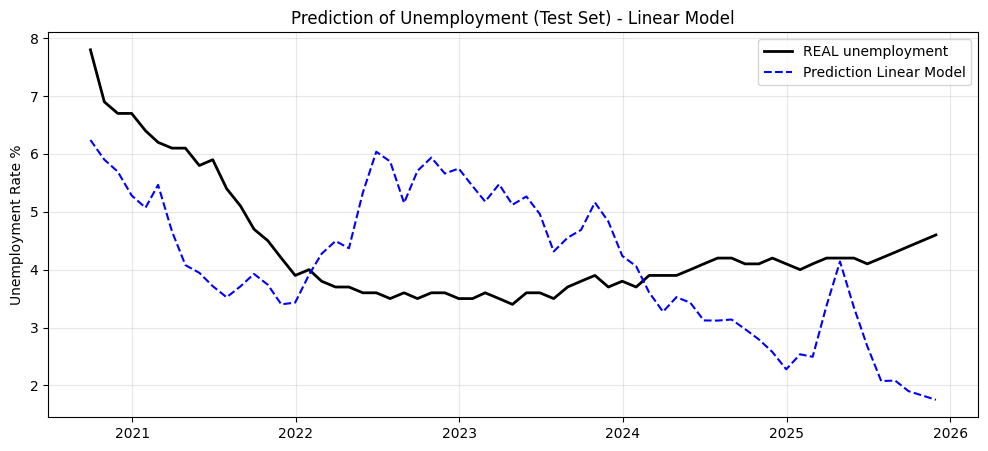

In [67]:
from sklearn.linear_model import LinearRegression

# build a linear model for the prediction of current month unemployment
linear_model = LinearRegression()
linear_model.fit(X_train_new, y_train_new)
predictions_linear = linear_model.predict(X_test_new)
mae_linear = (y_test_new - predictions_linear).abs().mean()
mape_linear = ((y_test_new - predictions_linear).abs() / y_test_new).mean() * 100
print("--- LINEAR MODEL RESULTS ---")
print(f"MAE: {mae_linear:.4f}")
print(f"MAPE: {mape_linear:.2f}%")
# plots
plt.figure(figsize=(12,5))
plt.plot(y_test_new.index, y_test_new, label='REAL unemployment', color='black', linewidth=2)
plt.plot(y_test_new.index, predictions_linear, label='Prediction Linear Model', color='blue', linestyle='--')
plt.title('Prediction of Unemployment (Test Set) - Linear Model')
plt.ylabel('Unemployment Rate %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

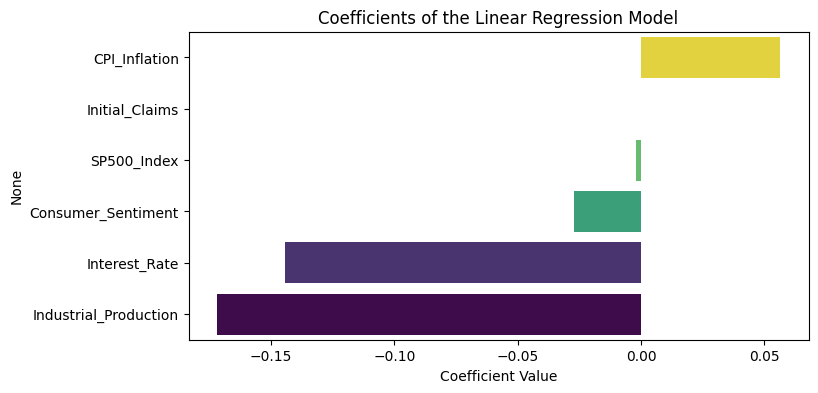

In [68]:
# coefficients of the linear model
coefficients = pd.Series(linear_model.coef_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=coefficients.values, y=coefficients.index, palette='viridis', hue = coefficients.values, legend=False)
plt.title('Coefficients of the Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.show()

The hypothesis test we need to perform is the following (according to what I have learnt in the subject Linear and Generalized Linear Models). If we want to test $H_0 : \beta_j = b_j$ ($b_j = 0$ in our case) against $H_1 : \beta_j \neq b_j$ ($b_j \neq 0$ in our case) at a significance level $\alpha$ ($0.05$ in our case), the decision rule for rejecting $H_0$ is:

$$\text{reject } H_0 \iff |T_j| \geq q_t\left(1- \frac{\alpha}{2}, n - p -1\right)$$

where $n$ is the number of individuals (observations for the training), $p$ is the number of variables, and 

$$T_j = \frac{\hat{\beta}_j - \beta_j}{\sqrt{\hat{\sigma}^2(X'X)^{-1}_{j+1, j+1}}}$$

where 

$$\hat{\sigma}^2 = \frac{\sum_{i = 1}^n (\hat{y}_i - y_i)^2}{n-p-1}$$

where $\hat{y}_i$ is the predicted value by the model and $y_i$ the actual value.

In [69]:
# print the coefficients of the model, to check the place of the sp500 index
print("Coefficients of the Linear Regression Model:")
for feature, coef in coefficients.items():
    print(f"{feature}: {coef:.4f}")

Coefficients of the Linear Regression Model:
CPI_Inflation: 0.0565
Initial_Claims: 0.0000
SP500_Index: -0.0019
Consumer_Sentiment: -0.0271
Interest_Rate: -0.1444
Industrial_Production: -0.1721


In [70]:
print(X_train_new.columns)

Index(['SP500_Index', 'Initial_Claims', 'Interest_Rate',
       'Industrial_Production', 'Consumer_Sentiment', 'CPI_Inflation'],
      dtype='object')


In [75]:
# obtain the coefficient for sp500 index
sp500_coefficient = coefficients['SP500_Index']
print(f"Coefficient for S&P 500 Index: {sp500_coefficient:.4f}")

# null hypothesis: the coefficient for sp500 index is 0
sp500_null_hypothesis = 0

# compute the residuals that would've been obtained in the training of the linear model
residuals = y_train_new - linear_model.predict(X_train_new)

# sum of the squared residuals
ssr = (residuals ** 2).sum()

# number of observations training
n = len(y_train_new)

# number of parameters
p = len(coefficients)

# compute the inverse of X*X^T
import numpy as np
X_train_scaled_with_intercept = np.hstack((np.ones((X_train_new.shape[0], 1)), X_train_new)) # we add the intercept: a column of ones
XtX_inv = np.linalg.inv(X_train_scaled_with_intercept.T @ X_train_scaled_with_intercept)

# compute the variance estimator
var_estimator = ssr / (n - p - 1)

# Tj statistic for sp500 coefficient
Tj = (sp500_coefficient - sp500_null_hypothesis) / np.sqrt(var_estimator * XtX_inv[1, 1]) # because sp500 is the first variable after intercept
print(f"Tj statistic for S&P 500 Index coefficient: {Tj:.4f}")


Coefficient for S&P 500 Index: -0.0019
Tj statistic for S&P 500 Index coefficient: -6.5177


In [74]:
y_train_new.shape

(248,)

We know have to check if this $T_j$ is inside the null hypothesis region or in the alternative hypothesis region.

In [76]:
from scipy.stats import t

alpha = 0.05
df = n - p - 1  # degrees of freedom

t_critical = t.ppf(1 - alpha / 2, df) # two tailed test on t- student

lower = -t_critical
upper = t_critical

print(f"Critical region: (-∞, {lower:.4f}] ∪ [{upper:.4f}, ∞)")


Critical region: (-∞, -1.9699] ∪ [1.9699, ∞)


Therefore, $T_j$ is in the ALTERNATIVE region. So it shouldn't be excluded from the model. Note that if we wanted to perform this test on the other variables, the confidence invertvals should be adjusted according to Bonferroni's principle.

Note that maybe a more qualitative way to see the dependance (more concretely, negative dependance) of unemployment with respect to SP500 bonds would be to directly plot their values in the studied period and see that when "one goes down, the other one goes up", and viceversa.

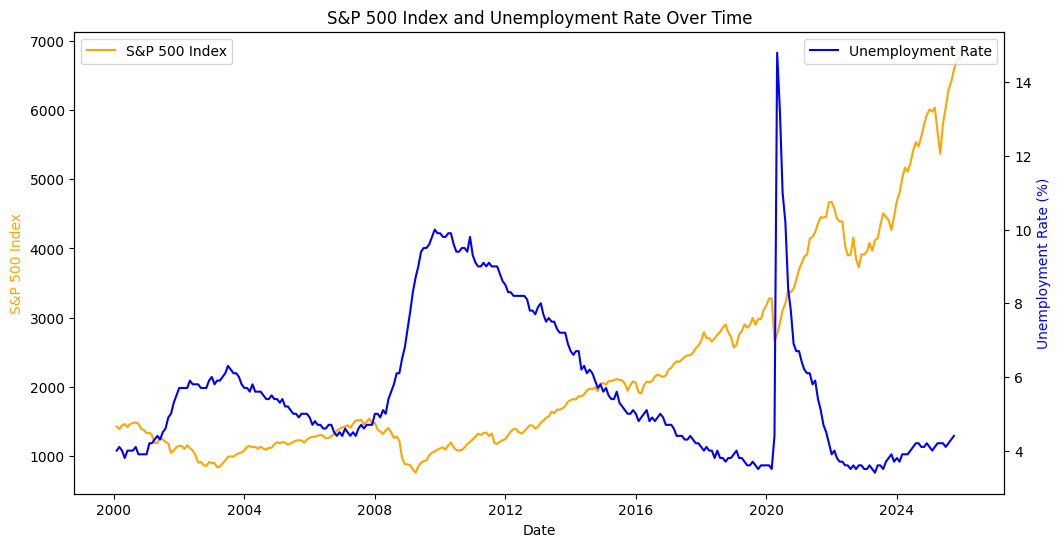

In [56]:
# plot the evolution of unemployment rate and sp500 index with different y axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df_monthly.index, df_monthly['SP500_Index'], label='S&P 500 Index', color='orange')
ax2.plot(df_monthly.index, df_monthly['Unemployment_Rate'], label='Unemployment Rate', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Index', color='orange')
ax2.set_ylabel('Unemployment Rate (%)', color='b')
plt.title('S&P 500 Index and Unemployment Rate Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Note that the model's performance is not great; in this part I was interested in showcasing the statistical study that I carried out.